<a href="https://colab.research.google.com/github/akash99955/Wine-Quality-prediction/blob/main/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# WINE QUALITY PREDICTION (BINARY) - FULL PIPELINE (CLEAN FORMAT)
# Models: Logistic Regression, Random Forest, SVM, One Neural Network
# Target: 0 = Poor Quality, 1 = Good Quality
# ============================================================

# ---------- Install dependencies (silent) ----------
!pip install -q pandas numpy scikit-learn matplotlib seaborn tensorflow

# ============================================================
# PART 1: SETUP + IMPORTS (FULL WORKING, CLEAN FORMAT)
# ============================================================

# 1) DATA + UTILITIES
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 2) VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# 3) SKLEARN (CLASSIC ML)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)

# 4) NEURAL NETWORK (TENSORFLOW / KERAS)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# Style settings (like your format)
# -----------------------------
plt.style.use("ggplot")
sns.set_theme(style="whitegrid", context="notebook")
sns.set_palette("Set2")
plt.rcParams["figure.dpi"] = 110

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(" All libraries imported successfully!")



 All libraries imported successfully!


In [ ]:
# ============================================================
# PART 2: LOAD DATASET + BASIC OVERVIEW (FULL WORKING, CLEAN FORMAT)
# WINE QUALITY PREDICTION (RED + WHITE WINE)
# ============================================================

# ---------- 1) Load datasets ----------
df_red = pd.read_csv("winequality-red.csv", delimiter=";")
df_white = pd.read_csv("winequality-white.csv", delimiter=";")

print(f" Red wine dataset  → {df_red.shape[0]:,} rows, {df_red.shape[1]} columns")
print(f" White wine dataset→ {df_white.shape[0]:,} rows, {df_white.shape[1]} columns")


# ---------- 2) Merge datasets ----------
df = pd.concat([df_red, df_white], ignore_index=True)

print(f"\n Combined dataset loaded → {df.shape[0]:,} samples")
print(f" Columns ({len(df.columns)}): {df.columns.tolist()}")


# ---------- 3) Create binary label (Good vs Poor) ----------
# Rule (standard in wine-quality ML papers):
#   Poor Quality  = quality <= 6  → label 0
#   Good Quality  = quality >= 7  → label 1

df["quality_label"] = (df["quality"] >= 7).astype(int)


# ---------- 4) Count each class safely ----------
quality_counts = df["quality_label"].value_counts(dropna=False)

poor_count = int(quality_counts.get(0, 0))
good_count = int(quality_counts.get(1, 0))

print("\n Wine Quality Distribution (numeric labels):")
print(f"   Poor Quality (0): {poor_count:,}")
print(f"   Good Quality (1): {good_count:,}")


# ---------- 5) Optional: readable label column ----------
label_map = {0: "Poor Quality", 1: "Good Quality"}
df["quality_text"] = df["quality_label"].map(label_map)


# ---------- 6) Dataset preview ----------
print("\n Sample rows from combined dataset:")
display(df.head())


# ---------- 7) Unique values + missing values summary ----------
unique_summary = (
    pd.DataFrame({
        "Column Name": df.columns,
        "Unique Values": [df[col].nunique(dropna=True) for col in df.columns],
        "Missing Values": [df[col].isna().sum() for col in df.columns],
        "Data Type": [df[col].dtype for col in df.columns]
    })
    .sort_values("Unique Values", ascending=False)
    .reset_index(drop=True)
)

print("\n Unique Values Summary (with missing values & data types):")
display(unique_summary)


 Red wine dataset  → 1,599 rows, 12 columns
 White wine dataset→ 4,898 rows, 12 columns

 Combined dataset loaded → 6,497 samples
 Columns (12): ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

 Wine Quality Distribution (numeric labels):
   Poor Quality (0): 5,220
   Good Quality (1): 1,277

 Sample rows from combined dataset:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_text
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,Poor Quality
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,Poor Quality
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,Poor Quality
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,Poor Quality
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,Poor Quality



 Unique Values Summary (with missing values & data types):


,Column Name,Unique Values,Missing Values,Data Type
0,density,998,0,float64
1,residual sugar,316,0,float64
2,total sulfur dioxide,276,0,float64
3,chlorides,214,0,float64
4,volatile acidity,187,0,float64
5,free sulfur dioxide,135,0,float64
6,sulphates,111,0,float64
7,alcohol,111,0,float64
8,pH,108,0,float64
9,fixed acidity,106,0,float64


In [ ]:
# chek the information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  quality_label         6497 non-null   int64  
 13  quality_text          6497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


In [ ]:
# checking the missing value of the data
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [ ]:
# Checking the dublicate data
df.duplicated().sum()

np.int64(1179)

In [ ]:
#delete the dublicate data
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
#checking the imbalance of data
target_distribution = df['quality'].value_counts()
print(target_distribution)

quality
6    2323
5    1751
7     855
4     206
8     148
3      30
9       5
Name: count, dtype: int64


In [ ]:
# calculate the class ratio of imbalance data
class_ratio = target_distribution / len(df)*100
print(class_ratio)

quality
6    43.681835
5    32.925912
7    16.077473
4     3.873637
8     2.783001
3     0.564122
9     0.094020
Name: count, dtype: float64


In [ ]:
# Adding missing values to 5 different rows in different columns
df.loc[10, 'fixed acidity'] = np.nan
df.loc[25, 'volatile acidity'] = np.nan
df.loc[42, 'citric acid'] = np.nan
df.loc[67, 'residual sugar'] = np.nan
df.loc[89, 'chlorides'] = np.nan
df.loc[105, 'free sulfur dioxide'] = np.nan
df.loc[150, 'total sulfur dioxide'] = np.nan
df.loc[200, 'density'] = np.nan
df.loc[250, 'pH'] = np.nan
df.loc[300, 'sulphates'] = np.nan
df.loc[350, 'alcohol'] = np.nan

In [ ]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_text
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5.0,0.0,Poor Quality
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5.0,0.0,Poor Quality
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5.0,0.0,Poor Quality
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6.0,0.0,Poor Quality
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5.0,0.0,Poor Quality
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5.0,0.0,Poor Quality
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6.0,0.0,Poor Quality
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7.0,1.0,Good Quality
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6.0,0.0,Poor Quality


In [ ]:
# For numeric wine features:
df['fixed acidity'] = df['fixed acidity'].fillna(df['fixed acidity'].mean()).round(2)
df['volatile acidity'] = df['volatile acidity'].fillna(df['volatile acidity'].mean()).round(2)
df['citric acid'] = df['citric acid'].fillna(df['citric acid'].mean()).round(2)
df['residual sugar'] = df['residual sugar'].fillna(df['residual sugar'].mean()).round(2)
df['chlorides'] = df['chlorides'].fillna(df['chlorides'].mean()).round(2)
df['free sulfur dioxide'] = df['free sulfur dioxide'].fillna(df['free sulfur dioxide'].mean()).round(2)
df['total sulfur dioxide'] = df['total sulfur dioxide'].fillna(df['total sulfur dioxide'].mean()).round(2)
df['density'] = df['density'].fillna(df['density'].mean()).round(3)  # 3 decimals for density
df['pH'] = df['pH'].fillna(df['pH'].mean()).round(2)
df['sulphates'] = df['sulphates'].fillna(df['sulphates'].mean()).round(2)
df['alcohol'] = df['alcohol'].fillna(df['alcohol'].mean()).round(2)


In [ ]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label,quality_text
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,0.998,3.51,0.56,9.40,5.0,0.0,Poor Quality
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,0.997,3.20,0.68,9.80,5.0,0.0,Poor Quality
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,0.997,3.26,0.65,9.80,5.0,0.0,Poor Quality
3,11.20,0.28,0.56,1.90,0.08,17.00,60.00,0.998,3.16,0.58,9.80,6.0,0.0,Poor Quality
5,7.40,0.66,0.00,1.80,0.08,13.00,40.00,0.998,3.51,0.56,9.40,5.0,0.0,Poor Quality
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,6.60,0.32,0.36,8.00,0.05,57.00,168.00,0.995,3.15,0.46,9.60,5.0,0.0,Poor Quality
6494,6.50,0.24,0.19,1.20,0.04,30.00,111.00,0.993,2.99,0.46,9.40,6.0,0.0,Poor Quality
6495,5.50,0.29,0.30,1.10,0.02,20.00,110.00,0.989,3.34,0.38,12.80,7.0,1.0,Good Quality
6496,6.00,0.21,0.38,0.80,0.02,22.00,98.00,0.989,3.26,0.32,11.80,6.0,0.0,Poor Quality


In [ ]:
# Create the category series directly
wine_categories = pd.Series(index=df.index, dtype='object')
wine_categories.loc[df['quality'] >= 7] = 'Good Quality'
wine_categories.loc[df['quality'] < 7] = 'Poor Quality'

# Count the categories
category_counts = wine_categories.value_counts()
print(category_counts)

Poor Quality    4310
Good Quality    1008
Name: count, dtype: int64


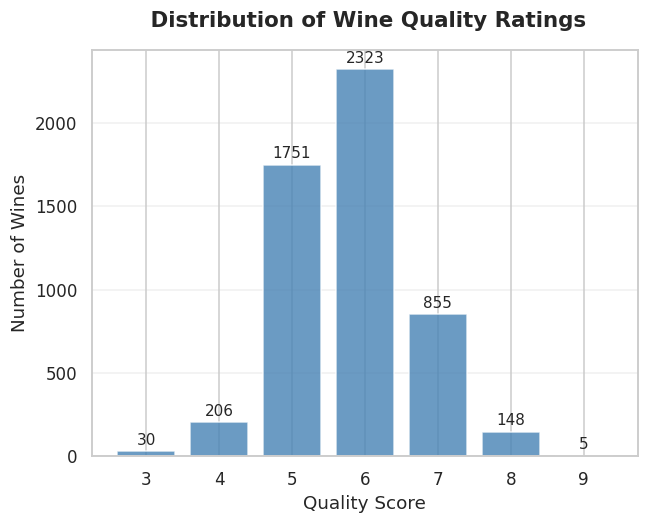

In [ ]:
# Quality Distribution
ax1 = plt.subplot(1, 1, 1)
quality_counts = df['quality'].value_counts().sort_index()
bars = ax1.bar(quality_counts.index, quality_counts.values, color='steelblue', alpha=0.8)
ax1.set_title(' Distribution of Wine Quality Ratings', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Quality Score', fontsize=12)
ax1.set_ylabel('Number of Wines', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)


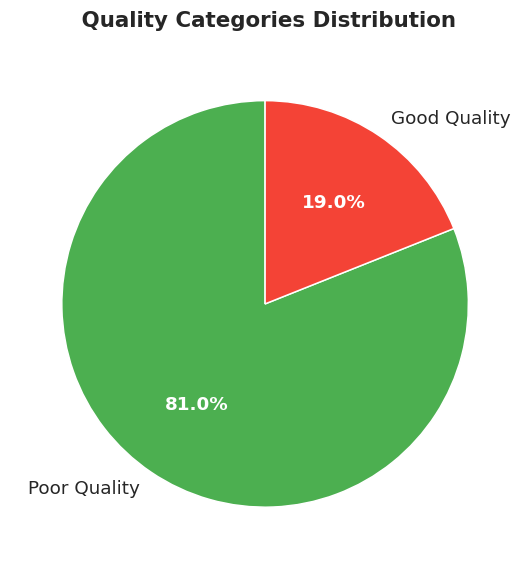

In [ ]:
# Quality Categories Pie Chart
plt.figure(figsize=(6,6)) # Create a new figure for this plot
ax2 = plt.subplot(1, 1, 1) # Use a single subplot for this figure
category_counts = wine_categories.value_counts()
colors = ['#4CAF50', '#F44336']
wedges, texts, autotexts = ax2.pie(category_counts.values, labels=category_counts.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90,
                                   textprops={'fontsize': 12})
ax2.set_title(' Quality Categories Distribution', fontsize=14, fontweight='bold', pad=15)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

Text(0.5, 1.0, ' Feature Correlation Matrix')

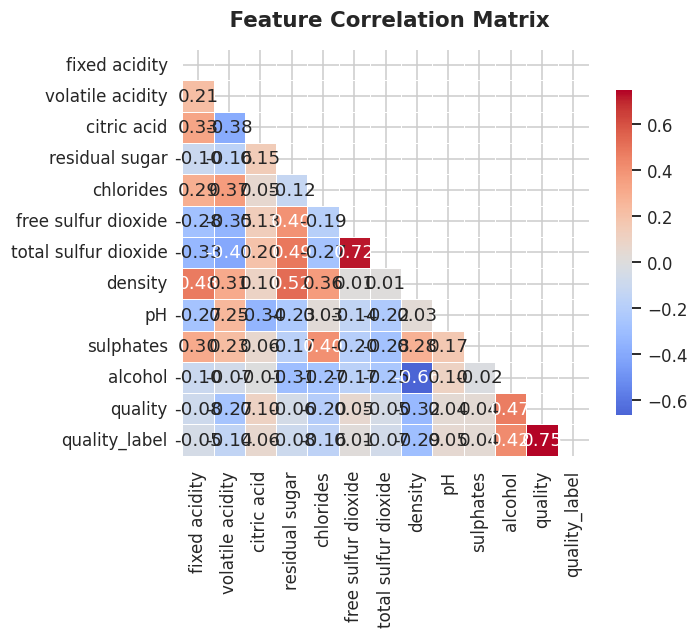

In [ ]:
# Feature Correlation Heatmap
ax3 = plt.subplot(1, 1, 1)
correlation_matrix = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax3)
ax3.set_title(' Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=15)


Text(0, 0.5, 'Alcohol (%)')

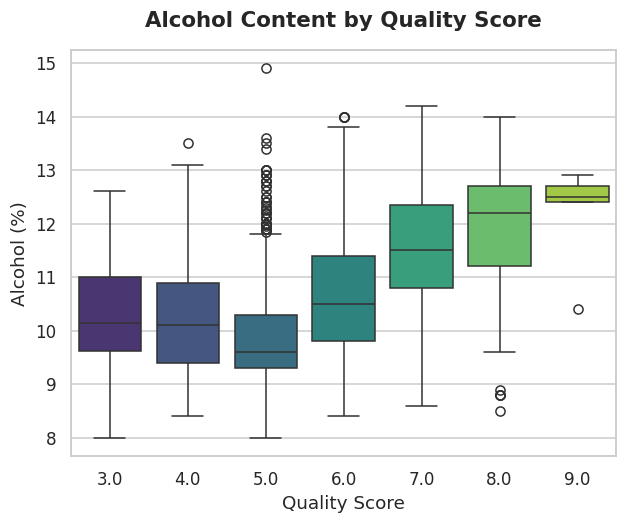

In [ ]:
# Alcohol vs Quality Boxplot
ax4 = plt.subplot(1, 1, 1)
sns.boxplot(x='quality', y='alcohol', data=df, palette='viridis', ax=ax4)
ax4.set_title('Alcohol Content by Quality Score', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Quality Score', fontsize=12)
ax4.set_ylabel('Alcohol (%)', fontsize=12)

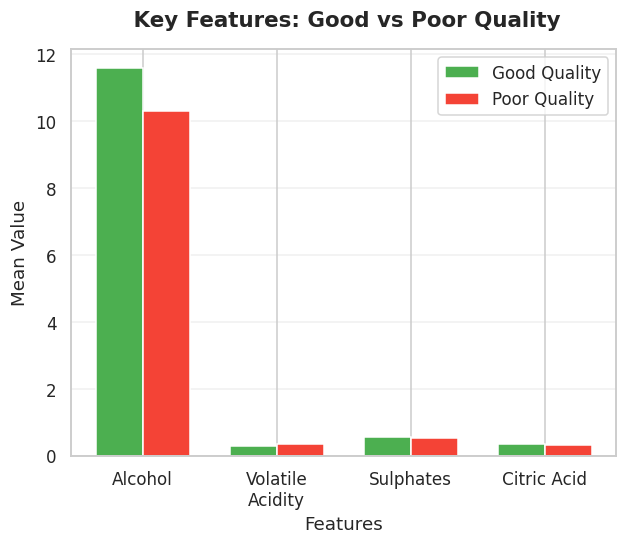

In [ ]:
# Key Features Comparison by Quality Category
ax5 = plt.subplot(1, 1, 1)
df['quality_category'] = wine_categories # Assign the series as a column
features_to_compare = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']
feature_means = df.groupby('quality_category')[features_to_compare].mean()
x = np.arange(len(features_to_compare))
width = 0.35
bars1 = ax5.bar(x - width/2, feature_means.loc['Good Quality'], width, label='Good Quality', color='#4CAF50')
bars2 = ax5.bar(x + width/2, feature_means.loc['Poor Quality'], width, label='Poor Quality', color='#F44336')
ax5.set_title(' Key Features: Good vs Poor Quality', fontsize=14, fontweight='bold', pad=15)
ax5.set_xlabel('Features', fontsize=12)
ax5.set_ylabel('Mean Value', fontsize=12)
ax5.set_xticks(x)
ax5.set_xticklabels(['Alcohol', 'Volatile\nAcidity', 'Sulphates', 'Citric Acid'])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

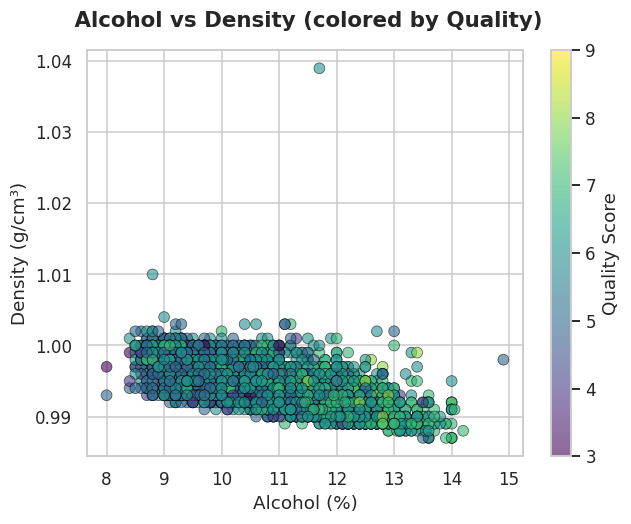

In [ ]:
# Scatter: Alcohol vs Density colored by Quality
ax7 = plt.subplot(1, 1, 1)
scatter = ax7.scatter(df['alcohol'], df['density'], c=df['quality'],
                     cmap='viridis', alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax7.set_title(' Alcohol vs Density (colored by Quality)', fontsize=14, fontweight='bold', pad=15)
ax7.set_xlabel('Alcohol (%)', fontsize=12)
ax7.set_ylabel('Density (g/cm³)', fontsize=12)
cbar = plt.colorbar(scatter, ax=ax7)
cbar.set_label('Quality Score', fontsize=12)

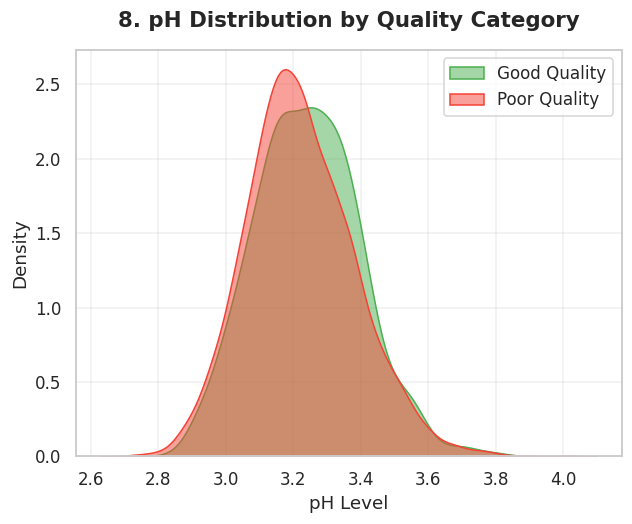

In [ ]:
#  pH Distribution by Quality Category
ax8 = plt.subplot(1, 1, 1)
for category, color in zip(['Good Quality', 'Poor Quality'], ['#4CAF50', '#F44336']):
    subset = df[df['quality_category'] == category]
    sns.kdeplot(data=subset['pH'], label=category, fill=True, alpha=0.5, color=color, ax=ax8)
ax8.set_title('8. pH Distribution by Quality Category', fontsize=14, fontweight='bold', pad=15)
ax8.set_xlabel('pH Level', fontsize=12)
ax8.set_ylabel('Density', fontsize=12)
ax8.legend()
ax8.grid(alpha=0.3)

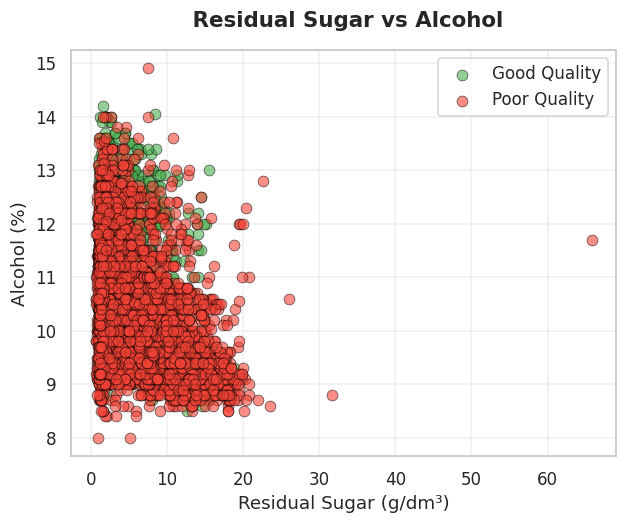

In [ ]:
# Residual Sugar vs Alcohol with Quality Categories
ax9 = plt.subplot(1, 1, 1)
good_quality = df[df['quality_category'] == 'Good Quality']
poor_quality = df[df['quality_category'] == 'Poor Quality']
ax9.scatter(good_quality['residual sugar'], good_quality['alcohol'],
           color='#4CAF50', alpha=0.6, s=50, label='Good Quality', edgecolor='black', linewidth=0.5)
ax9.scatter(poor_quality['residual sugar'], poor_quality['alcohol'],
           color='#F44336', alpha=0.6, s=50, label='Poor Quality', edgecolor='black', linewidth=0.5)
ax9.set_title(' Residual Sugar vs Alcohol', fontsize=14, fontweight='bold', pad=15)
ax9.set_xlabel('Residual Sugar (g/dm³)', fontsize=12)
ax9.set_ylabel('Alcohol (%)', fontsize=12)
ax9.legend()
ax9.grid(alpha=0.3)


=== Dataset Shape ===
Total samples: 5319, Features: 15

=== Class Distribution (quality_label) ===
quality_label
0.0    4310
1.0    1008
Name: count, dtype: int64
Percentage of 'Good' wines: 19.0%


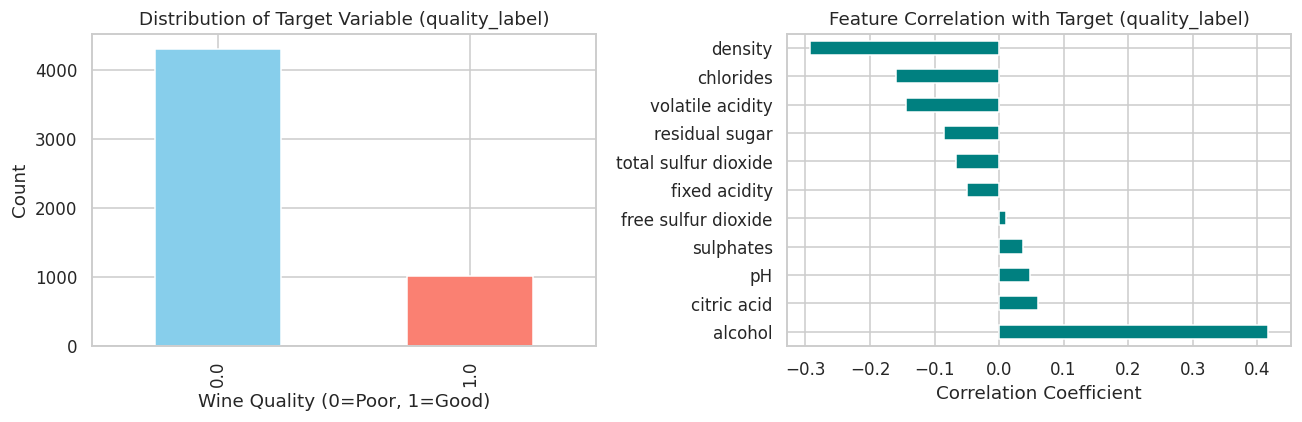

In [ ]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------
print("=== Dataset Shape ===")
print(f"Total samples: {df.shape[0]}, Features: {df.shape[1]}")
print(f"\n=== Class Distribution (quality_label) ===")
print(df['quality_label'].value_counts())
print(f"Percentage of 'Good' wines: {(df['quality_label'].mean()*100):.1f}%")

# Plot the class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df['quality_label'].value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribution of Target Variable (quality_label)')
ax1.set_xlabel('Wine Quality (0=Poor, 1=Good)')
ax1.set_ylabel('Count')

# Calculate and plot feature correlation with the target
# Ensure only numeric columns are used for correlation calculation.
# Then select correlations with 'quality_label' and remove self-correlation and correlation with 'quality'.
correlations = df.corr(numeric_only=True)['quality_label'].drop('quality_label', errors='ignore')
correlations = correlations.drop('quality', errors='ignore') # Exclude original 'quality' score
correlations = correlations.sort_values(ascending=False)

correlations.plot(kind='barh', ax=ax2, color='teal')
ax2.set_title('Feature Correlation with Target (quality_label)')
ax2.set_xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# PART 5: BALANCE DATASET + TRAIN/TEST SPLIT (CLEAN FORMAT)
# WINE QUALITY PREDICTION (GOOD vs POOR)
# ============================================================

print("\n Preparing a balanced training dataset...")


# ---------- 1) Check class counts ----------
class_counts = df["quality_label"].value_counts().sort_index()
min_per_class = int(class_counts.min())

print("\nClass counts (before balancing):")
label_names = {0: "Poor Quality", 1: "Good Quality"}
for label, cnt in class_counts.items():
    print(f"  {label} ({label_names[label]}): {cnt:,}")

print(f"\nBalancing to {min_per_class:,} samples per class...")


# ---------- 2) Balance each class safely ----------
balanced_data = (
    df.groupby("quality_label", group_keys=False)
      .apply(lambda x: x.sample(n=min_per_class, random_state=42))
      .sample(frac=1, random_state=42)   # shuffle dataset
      .reset_index(drop=True)
)

print(f"\n Balanced dataset created: {len(balanced_data):,} wine samples")


balanced_counts = balanced_data["quality_label"].value_counts().sort_index()
print("Balanced class counts:")
for label, cnt in balanced_counts.items():
    print(f"  {label} ({label_names[label]}): {cnt:,}")


# ---------- 3) Train-test split (stratified) ----------
train_df, test_df = train_test_split(
    balanced_data,
    test_size=0.20,
    random_state=42,
    stratify=balanced_data["quality_label"]
)

print("\n Train-Test Split Summary")
print(f"  Train samples: {len(train_df):,}")
print(f"  Test samples : {len(test_df):,}")


train_counts = train_df["quality_label"].value_counts().sort_index()
test_counts  = test_df["quality_label"].value_counts().sort_index()

print("\nTrain distribution:")
for label, cnt in train_counts.items():
    print(f"  {label} ({label_names[label]}): {cnt:,}")

print("\nTest distribution:")
for label, cnt in test_counts.items():
    print(f"  {label} ({label_names[label]}): {cnt:,}")



 Preparing a balanced training dataset...

Class counts (before balancing):
  0.0 (Poor Quality): 4,310
  1.0 (Good Quality): 1,008

Balancing to 1,008 samples per class...

 Balanced dataset created: 2,016 wine samples
Balanced class counts:
  0.0 (Poor Quality): 1,008
  1.0 (Good Quality): 1,008

 Train-Test Split Summary
  Train samples: 1,612
  Test samples : 404

Train distribution:
  0.0 (Poor Quality): 806
  1.0 (Good Quality): 806

Test distribution:
  0.0 (Poor Quality): 202
  1.0 (Good Quality): 202


In [ ]:
# 3. DATA PREPARATION FOR MODELING
# ------------------------------------------------------------
# Separate features (X) and target (y).
X = df.drop(columns=['quality', 'quality_label', 'quality_text', 'quality_category'])
y = df['quality_label']

# Drop rows where the target variable 'y' has NaN values
# This ensures that train_test_split does not encounter NaNs in the stratification step.
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# Split the data into training (80%) and testing (20%) sets.
# Using 'stratify=y' ensures the class ratio is preserved in both sets, which is crucial for imbalanced data[citation:2].
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features. This is essential for Logistic Regression and SVM.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# ===================================
# MODEL 1: RANDOM FOREST (WINE QUALITY)
# ===================================
# Task: Binary Classification
# 0 = Poor Quality, 1 = Good Quality

print("\n MODEL 1: RANDOM FOREST (WINE QUALITY)")
print("=" * 60)

# ------------------------------------------------------------
# STEP 1: FEATURE + TARGET SETUP
# ------------------------------------------------------------
print("\n STEP 1: FEATURE + TARGET SETUP")
print("-" * 45)

# Use the balanced train/test you created earlier:
# train_df, test_df  (from PART 5)

# Features = all numeric columns except label columns
drop_cols = ["quality_label"]
if "quality_text" in train_df.columns:
    drop_cols.append("quality_text")
if "quality" in train_df.columns:
    drop_cols.append("quality")   # prevent leakage
# Add 'quality_category' to drop_cols as it is a string column and not a feature
if "quality_category" in train_df.columns:
    drop_cols.append("quality_category")

X_train = train_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

y_train = train_df["quality_label"].values
y_true  = test_df["quality_label"].values

print(" Feature matrix prepared!")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape : {X_test.shape}")
print("   Target classes:", np.unique(y_train))


# ------------------------------------------------------------
# STEP 2: Random Forest Training
# ------------------------------------------------------------
print("\n STEP 2: TRAIN RANDOM FOREST")
print("-" * 45)

rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

t0 = time.time()
rf.fit(X_train, y_train)
train_time = time.time() - t0

print(f" Random Forest training completed in {train_time:.2f} sec")


# ------------------------------------------------------------
# STEP 3: Predictions
# ------------------------------------------------------------
print("\n STEP 3: PREDICTIONS")
print("-" * 45)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # prob of class 1 (Good)

print(" Predictions generated!")
print(f"   Sample preds : {y_pred_rf[:10]}")
print(f"   Sample probs : {np.round(y_prob_rf[:10], 3)}")


# ------------------------------------------------------------
# STEP 4: Evaluation
# ------------------------------------------------------------
print("\n STEP 4: MODEL EVALUATION")
print("-" * 45)

acc = accuracy_score(y_true, y_pred_rf)
cm  = confusion_matrix(y_true, y_pred_rf)

print(f" Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(
    y_true, y_pred_rf,
    target_names=["Poor Quality", "Good Quality"],
    digits=4
))





 MODEL 1: RANDOM FOREST (WINE QUALITY)

 STEP 1: FEATURE + TARGET SETUP
---------------------------------------------
 Feature matrix prepared!
   Train shape: (1612, 11)
   Test shape : (404, 11)
   Target classes: [0. 1.]

 STEP 2: TRAIN RANDOM FOREST
---------------------------------------------
 Random Forest training completed in 7.04 sec

 STEP 3: PREDICTIONS
---------------------------------------------
 Predictions generated!
   Sample preds : [0. 1. 1. 1. 0. 1. 0. 1. 0. 0.]
   Sample probs : [0.453 0.839 0.834 0.595 0.106 0.779 0.105 0.629 0.393 0.498]

 STEP 4: MODEL EVALUATION
---------------------------------------------
 Accuracy: 0.7698

 Classification Report:
              precision    recall  f1-score   support

Poor Quality     0.7978    0.7228    0.7584       202
Good Quality     0.7466    0.8168    0.7801       202

    accuracy                         0.7698       404
   macro avg     0.7722    0.7698    0.7693       404
weighted avg     0.7722    0.7698    0.7693

In [ ]:
# ==========================================
# MODEL 2: LOGISTIC REGRESSION (WINE QUALITY)
# ==========================================
# Task: Binary Classification
# 0 = Poor Quality, 1 = Good Quality

print("\n MODEL 2: LOGISTIC REGRESSION (WINE QUALITY)")
print("=" * 60)

# ------------------------------------------------------------
# STEP 1: FEATURE + TARGET SETUP
# ------------------------------------------------------------
print("\n STEP 1: FEATURE + TARGET SETUP")
print("-" * 45)

# Use the balanced train/test you created earlier:
# train_df, test_df  (from PART 5)

# Features = all numeric columns except label columns
drop_cols = ["quality_label"]
if "quality_text" in train_df.columns:
    drop_cols.append("quality_text")
if "quality" in train_df.columns:
    drop_cols.append("quality")   # prevent leakage
# Add 'quality_category' to drop_cols as it is a string column and not a feature
if "quality_category" in train_df.columns:
    drop_cols.append("quality_category")

X_train = train_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

y_train = train_df["quality_label"].values
y_true  = test_df["quality_label"].values

print(" Feature matrix prepared!")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape : {X_test.shape}")
print("   Target classes:", np.unique(y_train))


# ------------------------------------------------------------
# STEP 2: Standard Scaling (IMPORTANT for Logistic Regression)
# ------------------------------------------------------------
print("\n STEP 2: FEATURE SCALING (STANDARD SCALER)")
print("-" * 45)

scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train)
X_test_lr  = scaler_lr.transform(X_test)

print(" Scaling done!")
print(f"   Train scaled shape: {X_train_lr.shape}")
print(f"   Test scaled shape : {X_test_lr.shape}")


# ------------------------------------------------------------
# STEP 3: Logistic Regression Training
# ------------------------------------------------------------
print("\n STEP 3: TRAIN LOGISTIC REGRESSION")
print("-" * 45)

lr = LogisticRegression(
    max_iter=3000,
    solver="lbfgs",
    class_weight="balanced",
    random_state=42
)

t0 = time.time()
lr.fit(X_train_lr, y_train)
train_time = time.time() - t0

print(f" Logistic Regression training completed in {train_time:.2f} sec")


# ------------------------------------------------------------
# STEP 4: Predictions
# ------------------------------------------------------------
print("\n STEP 4: PREDICTIONS")
print("-" * 45)

y_pred_lr = lr.predict(X_test_lr)
y_prob_lr = lr.predict_proba(X_test_lr)[:, 1]   # prob of class 1 (Good)

print(" Predictions generated!")
print(f"   Sample preds : {y_pred_lr[:10]}")
print(f"   Sample probs : {np.round(y_prob_lr[:10], 3)}")


# ------------------------------------------------------------
# STEP 5: Evaluation
# ------------------------------------------------------------
print("\n STEP 5: MODEL EVALUATION")
print("-" * 45)

acc = accuracy_score(y_true, y_pred_lr)
cm  = confusion_matrix(y_true, y_pred_lr)

print(f" Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(
    y_true, y_pred_lr,
    target_names=["Poor Quality", "Good Quality"],
    digits=4
))




 MODEL 2: LOGISTIC REGRESSION (WINE QUALITY)

 STEP 1: FEATURE + TARGET SETUP
---------------------------------------------
 Feature matrix prepared!
   Train shape: (1612, 11)
   Test shape : (404, 11)
   Target classes: [0. 1.]

 STEP 2: FEATURE SCALING (STANDARD SCALER)
---------------------------------------------
 Scaling done!
   Train scaled shape: (1612, 11)
   Test scaled shape : (404, 11)

 STEP 3: TRAIN LOGISTIC REGRESSION
---------------------------------------------
 Logistic Regression training completed in 0.05 sec

 STEP 4: PREDICTIONS
---------------------------------------------
 Predictions generated!
   Sample preds : [1. 1. 1. 1. 0. 1. 0. 1. 0. 1.]
   Sample probs : [0.647 0.793 0.899 0.64  0.128 0.88  0.226 0.543 0.181 0.67 ]

 STEP 5: MODEL EVALUATION
---------------------------------------------
 Accuracy: 0.7649

 Classification Report:
              precision    recall  f1-score   support

Poor Quality     0.7861    0.7277    0.7558       202
Good Quality    

In [ ]:
# ================================
# MODEL 3: SVM (WINE QUALITY)
# ================================
# Task: Binary Classification
# 0 = Poor Quality, 1 = Good Quality

print("\n MODEL 3: SUPPORT VECTOR MACHINE (WINE QUALITY)")
print("=" * 60)

# ------------------------------------------------------------
# STEP 1: FEATURE + TARGET SETUP
# ------------------------------------------------------------
print("\n STEP 1: FEATURE + TARGET SETUP")
print("-" * 45)

# Use the balanced train/test you created earlier:
# train_df, test_df  (from PART 5)

# Features = all numeric columns except label columns
drop_cols = ["quality_label"]
if "quality_text" in train_df.columns:
    drop_cols.append("quality_text")
if "quality" in train_df.columns:
    drop_cols.append("quality")   # prevent leakage
# Add 'quality_category' to drop_cols as it is a string column and not a feature
if "quality_category" in train_df.columns:
    drop_cols.append("quality_category")

X_train = train_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

y_train = train_df["quality_label"].values
y_true  = test_df["quality_label"].values

print(" Feature matrix prepared!")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape : {X_test.shape}")
print("   Target classes:", np.unique(y_train))


# ------------------------------------------------------------
# STEP 2: Feature Scaling (MANDATORY for SVM)
# ------------------------------------------------------------
print("\n STEP 2: FEATURE SCALING (STANDARD SCALER)")
print("-" * 45)

scaler_svm = StandardScaler()
X_train_svm = scaler_svm.fit_transform(X_train)
X_test_svm  = scaler_svm.transform(X_test)

print(" Scaling done!")
print(f"   Train scaled shape: {X_train_svm.shape}")
print(f"   Test scaled shape : {X_test_svm.shape}")


# ------------------------------------------------------------
# STEP 3: SVM Training (RBF Kernel)
# ------------------------------------------------------------
print("\n STEP 3: TRAIN SVM (RBF KERNEL)")
print("-" * 45)

svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,          # needed for ROC / PR curves
    class_weight="balanced",
    random_state=42
)

t0 = time.time()
svm.fit(X_train_svm, y_train)
train_time = time.time() - t0

print(f" SVM training completed in {train_time:.2f} sec")


# ------------------------------------------------------------
# STEP 4: Predictions
# ------------------------------------------------------------
print("\n STEP 4: PREDICTIONS")
print("-" * 45)

y_pred_svm = svm.predict(X_test_svm)
y_prob_svm = svm.predict_proba(X_test_svm)[:, 1]  # prob of class 1 (Good)

print(" Predictions generated!")
print(f"   Sample preds : {y_pred_svm[:10]}")
print(f"   Sample probs : {np.round(y_prob_svm[:10], 3)}")


# ------------------------------------------------------------
# STEP 5: Evaluation
# ------------------------------------------------------------
print("\n STEP 5: MODEL EVALUATION")
print("-" * 45)

acc = accuracy_score(y_true, y_pred_svm)
cm  = confusion_matrix(y_true, y_pred_svm)

print(f" Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(
    y_true, y_pred_svm,
    target_names=["Poor Quality", "Good Quality"],
    digits=4
))





 MODEL 3: SUPPORT VECTOR MACHINE (WINE QUALITY)

 STEP 1: FEATURE + TARGET SETUP
---------------------------------------------
 Feature matrix prepared!
   Train shape: (1612, 11)
   Test shape : (404, 11)
   Target classes: [0. 1.]

 STEP 2: FEATURE SCALING (STANDARD SCALER)
---------------------------------------------
 Scaling done!
   Train scaled shape: (1612, 11)
   Test scaled shape : (404, 11)

 STEP 3: TRAIN SVM (RBF KERNEL)
---------------------------------------------
 SVM training completed in 0.79 sec

 STEP 4: PREDICTIONS
---------------------------------------------
 Predictions generated!
   Sample preds : [1. 1. 1. 1. 0. 1. 0. 1. 0. 1.]
   Sample probs : [0.668 0.829 0.793 0.758 0.151 0.885 0.169 0.588 0.168 0.737]

 STEP 5: MODEL EVALUATION
---------------------------------------------
 Accuracy: 0.7921

 Classification Report:
              precision    recall  f1-score   support

Poor Quality     0.8278    0.7376    0.7801       202
Good Quality     0.7634    0.846


 MODEL 4: NEURAL NETWORK (WINE QUALITY)

 STEP 1: FEATURE + TARGET SETUP
---------------------------------------------
 Feature matrix prepared!
   Train shape: (1612, 11)
   Test shape : (404, 11)
   Target classes: [0. 1.]

 STEP 2: FEATURE SCALING (STANDARD SCALER)
---------------------------------------------
 Scaling done!
   Train scaled shape: (1612, 11)
   Test scaled shape : (404, 11)

 STEP 3: CLASS WEIGHTS (IMBALANCE HANDLING)
---------------------------------------------
 Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

 STEP 4: BUILD NEURAL NETWORK
---------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)


 STEP 5: TRAIN NEURAL NETWORK
---------------------------------------------
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5884 - loss: 0.6465 - val_accuracy: 0.7430 - val_loss: 0.5682
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7383 - loss: 0.5619 - val_accuracy: 0.7554 - val_loss: 0.5521
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7549 - loss: 0.5327 - val_accuracy: 0.7616 - val_loss: 0.5466
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7629 - loss: 0.5294 - val_accuracy: 0.7585 - val_loss: 0.5459
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7632 - loss: 0.5276 - val_accuracy: 0.7554 - val_loss: 0.5411
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7657 - loss: 0.5140 - val_accuracy: 0.7647 - val_loss: 0.5413
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7665 - loss: 0.5135 - val_accuracy: 0.7678 - val_loss: 0.5356
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1

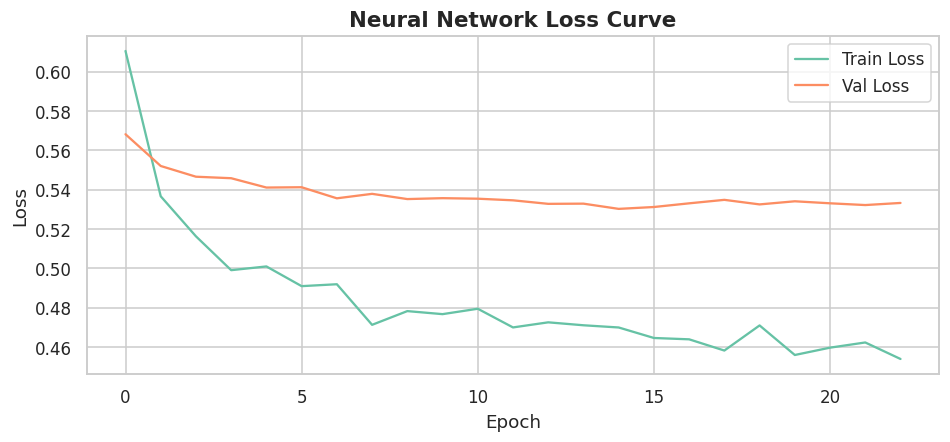

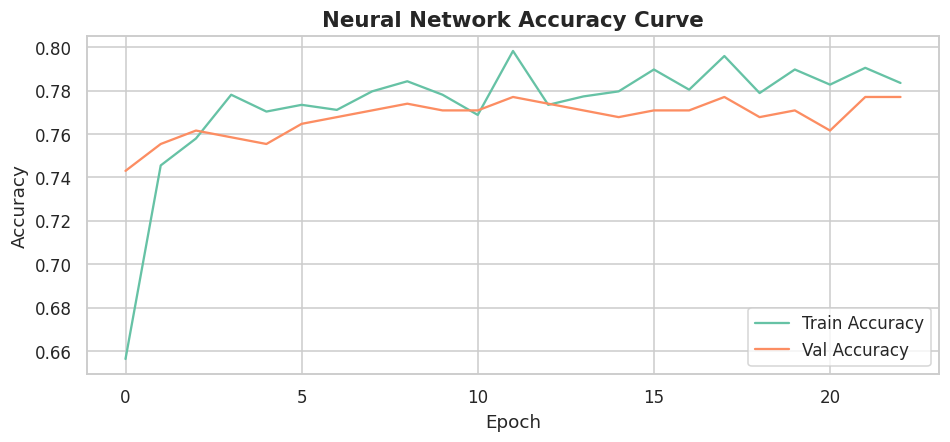

In [ ]:
# ================================
# MODEL 4: NEURAL NETWORK (WINE QUALITY)
# ================================
# Task: Binary Classification
# 0 = Poor Quality, 1 = Good Quality

print("\n MODEL 4: NEURAL NETWORK (WINE QUALITY)")
print("=" * 60)

# ------------------------------------------------------------
# STEP 1: FEATURE + TARGET SETUP
# ------------------------------------------------------------
print("\n STEP 1: FEATURE + TARGET SETUP")
print("-" * 45)

# Use the balanced train/test you created earlier:
# train_df, test_df  (from PART 5)

drop_cols = ["quality_label"]
if "quality_text" in train_df.columns:
    drop_cols.append("quality_text")
if "quality" in train_df.columns:
    drop_cols.append("quality")   # prevent leakage
# Add 'quality_category' to drop_cols as it is a string column and not a feature
if "quality_category" in train_df.columns:
    drop_cols.append("quality_category")

X_train = train_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

y_train = train_df["quality_label"].values
y_true  = test_df["quality_label"].values

print(" Feature matrix prepared!")
print(f"   Train shape: {X_train.shape}")
print(f"   Test shape : {X_test.shape}")
print("   Target classes:", np.unique(y_train))


# ------------------------------------------------------------
# STEP 2: Feature Scaling (IMPORTANT for Neural Network)
# ------------------------------------------------------------
print("\n STEP 2: FEATURE SCALING (STANDARD SCALER)")
print("-" * 45)

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn  = scaler_nn.transform(X_test)

print(" Scaling done!")
print(f"   Train scaled shape: {X_train_nn.shape}")
print(f"   Test scaled shape : {X_test_nn.shape}")


# ------------------------------------------------------------
# STEP 3: Class Weights (Handle imbalance safely)
# ------------------------------------------------------------
print("\n STEP 3: CLASS WEIGHTS (IMBALANCE HANDLING)")
print("-" * 45)

classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print(" Class weights:", class_weight)


# ------------------------------------------------------------
# STEP 4: Build Neural Network Model (One NN)
# ------------------------------------------------------------
print("\n STEP 4: BUILD NEURAL NETWORK")
print("-" * 45)

nn_model = keras.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),

    layers.Dense(64, activation="relu"),
    layers.Dropout(0.25),

    layers.Dense(32, activation="relu"),
    layers.Dropout(0.20),

    layers.Dense(1, activation="sigmoid")   # binary output
])

nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

nn_model.summary()


# ------------------------------------------------------------
# STEP 5: Train Neural Network (Early Stopping)
# ------------------------------------------------------------
print("\n STEP 5: TRAIN NEURAL NETWORK")
print("-" * 45)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

t0 = time.time()
history = nn_model.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)
train_time = time.time() - t0

print(f" Neural Network training completed in {train_time:.2f} sec")


# ------------------------------------------------------------
# STEP 6: Predictions
# ------------------------------------------------------------
print("\n STEP 6: PREDICTIONS")
print("-" * 45)

y_prob_nn = nn_model.predict(X_test_nn).ravel()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

print(" Predictions generated!")
print(f"   Sample preds : {y_pred_nn[:10]}")
print(f"   Sample probs : {np.round(y_prob_nn[:10], 3)}")


# ------------------------------------------------------------
# STEP 7: Evaluation
# ------------------------------------------------------------
print("\n STEP 7: MODEL EVALUATION")
print("-" * 45)

acc = accuracy_score(y_true, y_pred_nn)
cm  = confusion_matrix(y_true, y_pred_nn)

print(f" Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(
    y_true, y_pred_nn,
    target_names=["Poor Quality", "Good Quality"],
    digits=4
))


# ------------------------------------------------------------
# STEP 8: Training Curves (Loss + Accuracy)
# ------------------------------------------------------------
print("\n STEP 8: TRAINING CURVES")
print("-" * 45)

plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Neural Network Loss Curve", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Neural Network Accuracy Curve", fontsize=14, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


WINE QUALITY: ALL MODEL COMPARISON (LR vs RF vs SVM vs NN)

Performance Metrics Comparison (ALL MODELS):
----------------------------------------------------------------------
              Model  Accuracy  F1-Score  Precision   Recall
                SVM  0.792079  0.791461   0.795585 0.792079
     Neural Network  0.769802  0.769563   0.770924 0.769802
      Random Forest  0.769802  0.769292   0.772210 0.769802
Logistic Regression  0.764851  0.764527   0.766320 0.764851


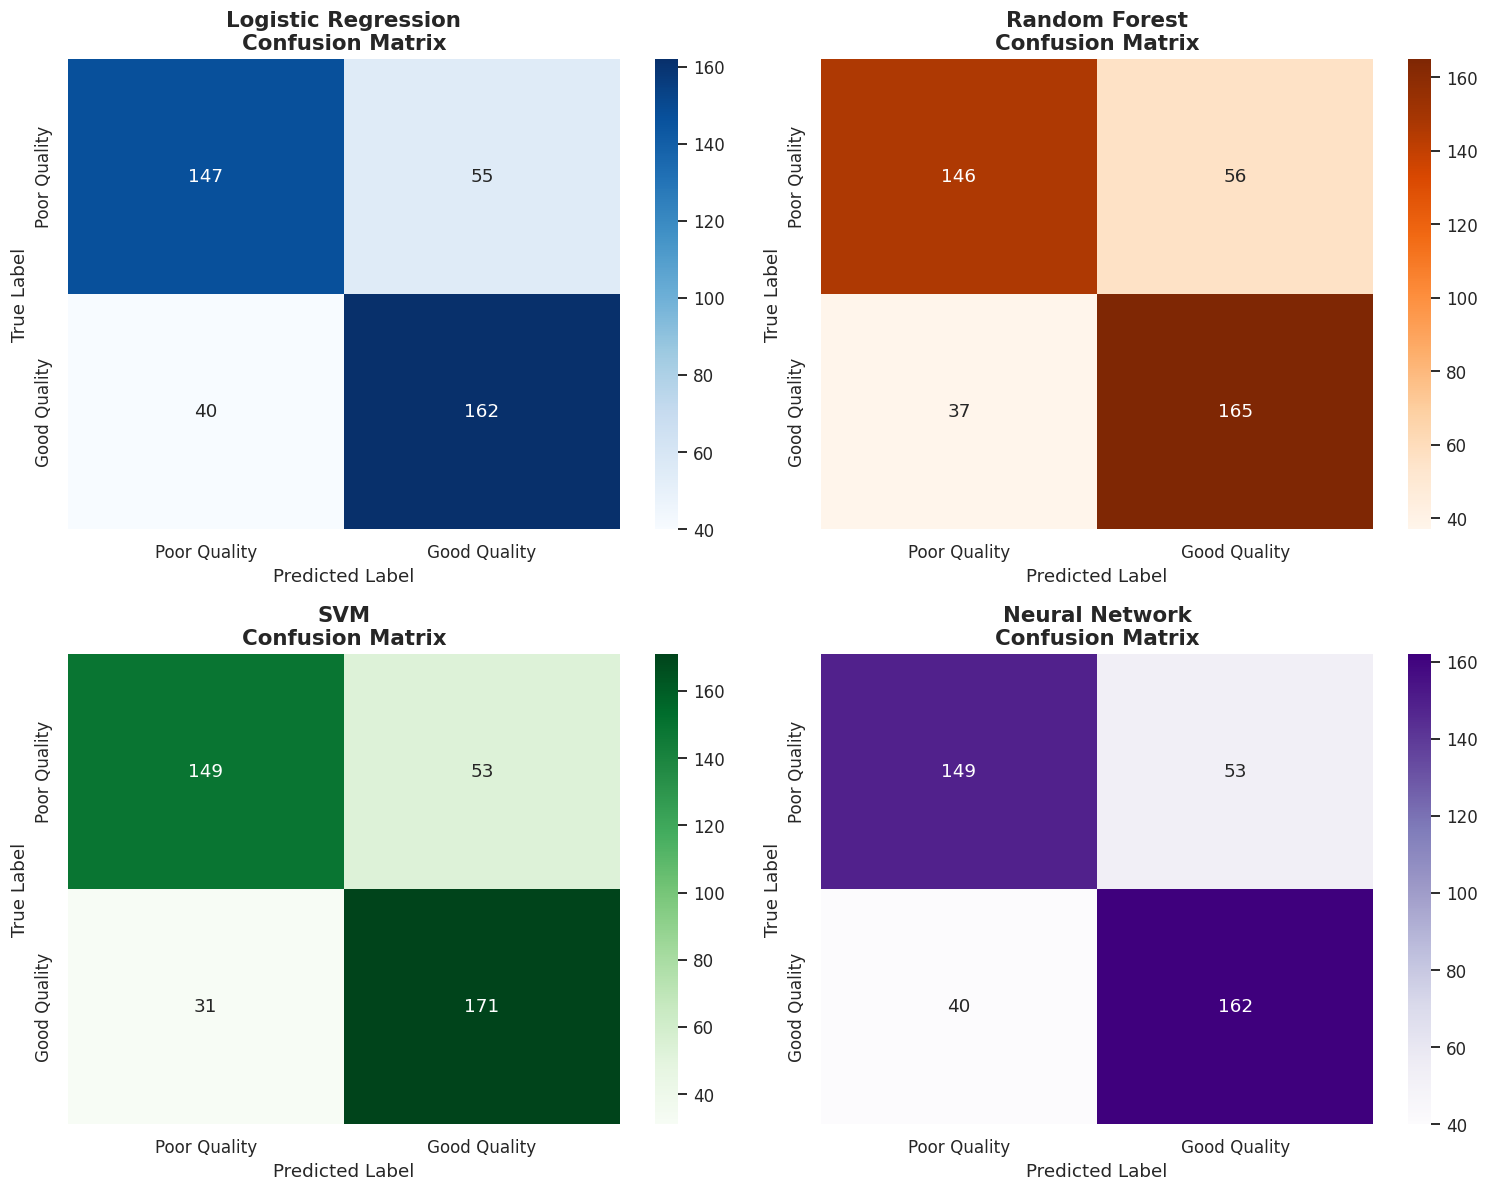

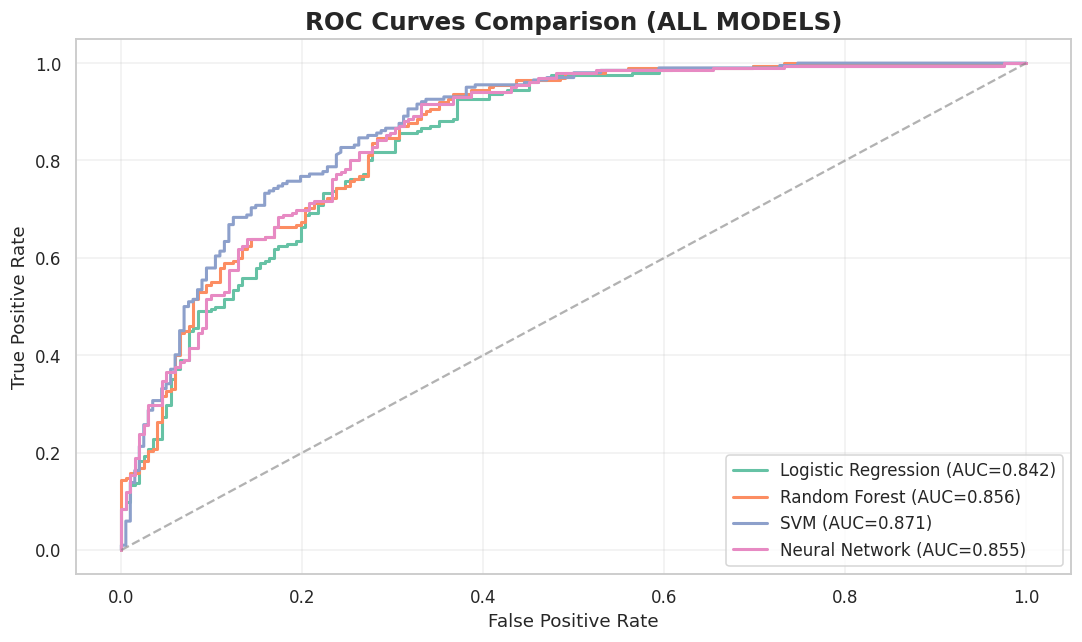

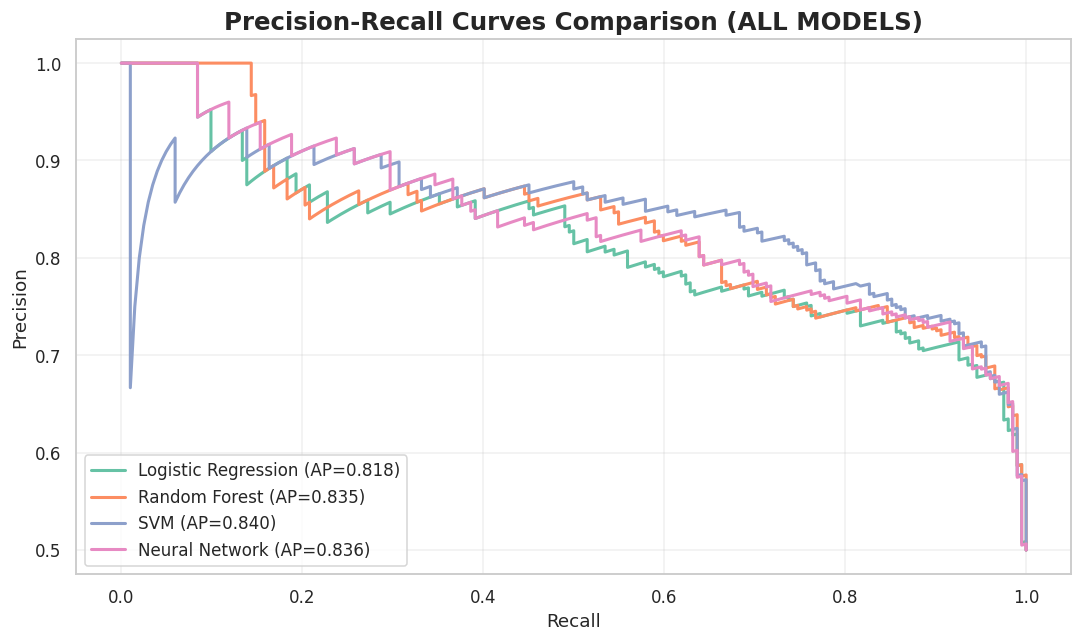

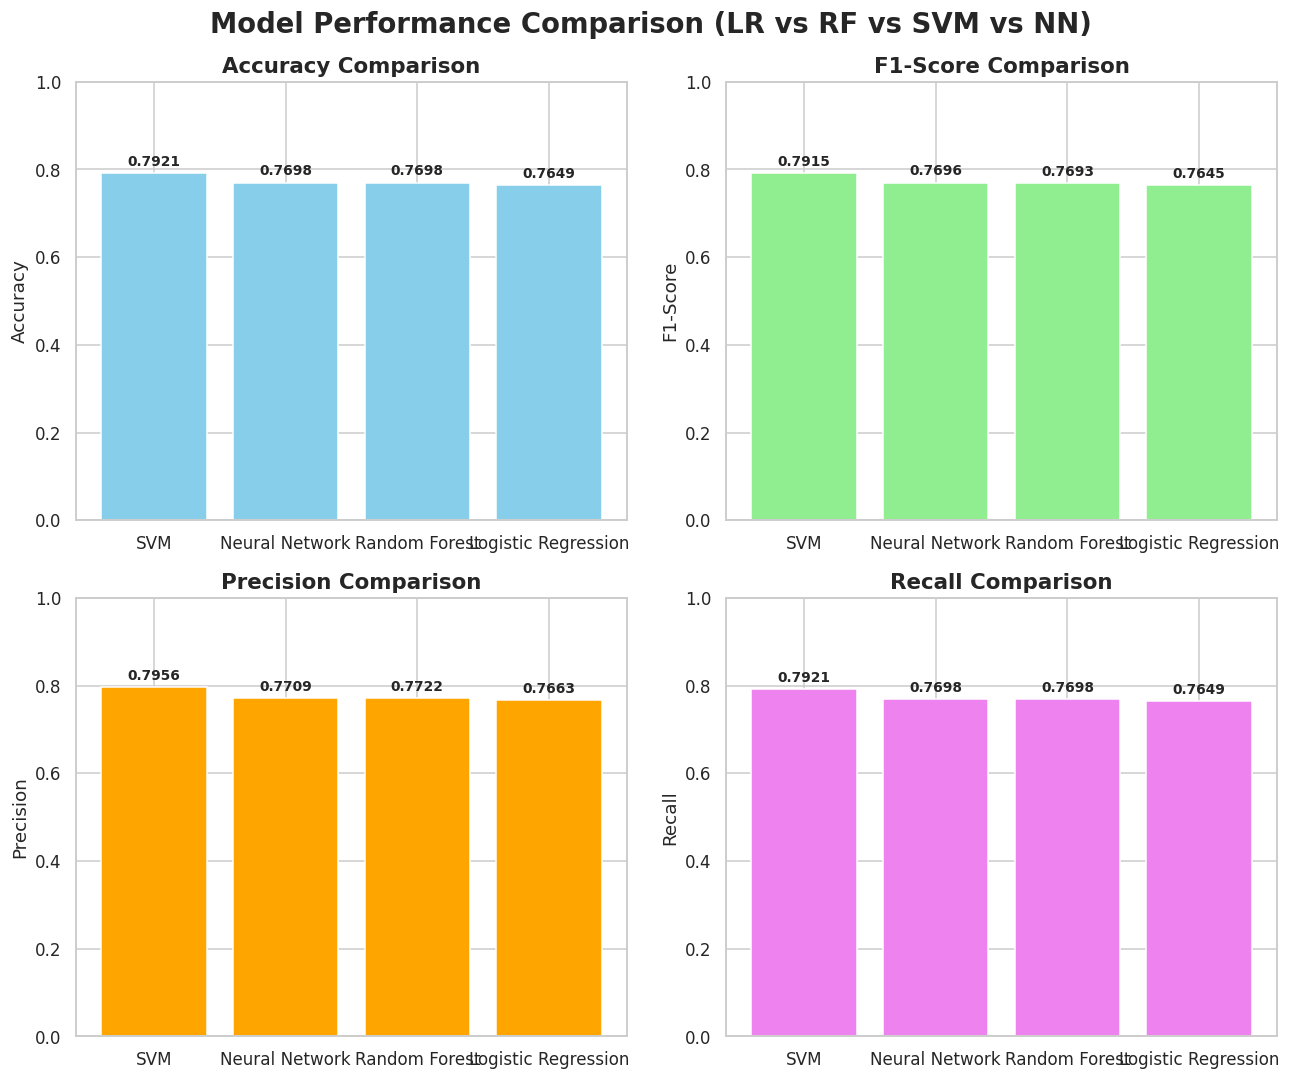


Best Model (by F1-Score): SVM

Classification Report:
              precision    recall  f1-score   support

Poor Quality     0.8278    0.7376    0.7801       202
Good Quality     0.7634    0.8465    0.8028       202

    accuracy                         0.7921       404
   macro avg     0.7956    0.7921    0.7915       404
weighted avg     0.7956    0.7921    0.7915       404



In [ ]:
# ======================================================
# WINE QUALITY: ALL MODEL COMPARISON
# Models: Logistic Regression, Random Forest, SVM, Neural Network
# Includes: StandardScaler for LR/SVM/NN
# Outputs: Metrics table + Confusion Matrices + ROC + PR + Bar charts
# ======================================================

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score, precision_score, recall_score,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

print("\n" + "="*70)
print("WINE QUALITY: ALL MODEL COMPARISON (LR vs RF vs SVM vs NN)")
print("="*70)

# ------------------------------------------------------------
# STEP 1: Collect true labels + predictions from each model
# ------------------------------------------------------------
y_true = test_df["quality_label"].values

# IMPORTANT:
# You must already have these variables from your model training cells:
# y_pred_lr, y_prob_lr
# y_pred_rf, y_prob_rf
# y_pred_svm, y_prob_svm
# y_pred_nn, y_prob_nn

model_outputs = {
    "Logistic Regression": {"pred": y_pred_lr,  "prob": y_prob_lr},
    "Random Forest":       {"pred": y_pred_rf,  "prob": y_prob_rf},
    "SVM":                 {"pred": y_pred_svm, "prob": y_prob_svm},
    "Neural Network":      {"pred": y_pred_nn,  "prob": y_prob_nn},
}

class_labels = ["Poor Quality", "Good Quality"]


# ======================================================
# STEP 2: Metrics Table (Accuracy, F1, Precision, Recall)
# ======================================================
rows = []
for name, out in model_outputs.items():
    y_pred = out["pred"]

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
    })

comparison_df = pd.DataFrame(rows).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\nPerformance Metrics Comparison (ALL MODELS):")
print("-" * 70)
print(comparison_df.to_string(index=False))


# ======================================================
# STEP 3: Confusion Matrices (2x2 Grid)
# ======================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
axes = axes.flatten()

cmaps = ["Blues", "Oranges", "Greens", "Purples"]

for i, (name, out) in enumerate(model_outputs.items()):
    cm = confusion_matrix(y_true, out["pred"])

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmaps[i],
        xticklabels=class_labels,
        yticklabels=class_labels,
        ax=axes[i]
    )
    axes[i].set_title(f"{name}\nConfusion Matrix", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Predicted Label", fontsize=12)
    axes[i].set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()


# ======================================================
# STEP 4: ROC Curve Comparison (ALL MODELS)
# ======================================================
plt.figure(figsize=(10, 6))

for name, out in model_outputs.items():
    fpr, tpr, _ = roc_curve(y_true, out["prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves Comparison (ALL MODELS)", fontsize=16, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# STEP 5: Precision-Recall Curve Comparison (ALL MODELS)
# ======================================================
plt.figure(figsize=(10, 6))

for name, out in model_outputs.items():
    precision, recall, _ = precision_recall_curve(y_true, out["prob"])
    ap = average_precision_score(y_true, out["prob"])
    plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curves Comparison (ALL MODELS)", fontsize=16, fontweight="bold")
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ======================================================
# STEP 6: Bar Charts (Accuracy, F1, Precision, Recall)
# ======================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metrics = ["Accuracy", "F1-Score", "Precision", "Recall"]
colors = ["skyblue", "lightgreen", "orange", "violet"]

for idx, metric in enumerate(metrics):
    bars = axes[idx].bar(
        comparison_df["Model"],
        comparison_df[metric],
        color=colors[idx]
    )
    axes[idx].set_title(f"{metric} Comparison", fontsize=14, fontweight="bold")
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_ylim([0.0, 1.0])

    for bar, val in zip(bars, comparison_df[metric]):
        axes[idx].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{val:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

plt.suptitle("Model Performance Comparison (LR vs RF vs SVM vs NN)", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


# ======================================================
# STEP 7: Print Best Model Full Report (by F1)
# ======================================================
best_model = comparison_df.iloc[0]["Model"]
print("\nBest Model (by F1-Score):", best_model)
print("\nClassification Report:")
print(classification_report(
    y_true,
    model_outputs[best_model]["pred"],
    target_names=class_labels,
    digits=4
))


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assign the best model (SVM) to the 'model' variable and its corresponding scaler
model = svm
scaler_for_prediction = scaler_svm

feature_cols = X.columns.tolist()

mins = df[feature_cols].min()
maxs = df[feature_cols].max()
means = df[feature_cols].mean()

inputs = []
widgets_map = {}

for col in feature_cols:
    step = 1.0 if col in ["free sulfur dioxide", "total sulfur dioxide"] else 0.01
    slider = widgets.FloatSlider(
        value=float(means[col]),
        min=float(mins[col]),
        max=float(maxs[col]),
        step=step,
        description=col[:16],
        layout=widgets.Layout(width="95%"),
        continuous_update=False
    )
    widgets_map[col] = slider
    inputs.append(slider)

btn = widgets.Button(
    description="Predict Wine Quality",
    button_style="success",
    icon="check"
)

output_box = widgets.Output()

def predict(_):
    with output_box:
        clear_output()
        user_input = {c: widgets_map[c].value for c in feature_cols}
        X_input = pd.DataFrame([user_input], columns=feature_cols)

        # Scale the input features using the scaler corresponding to the selected model
        X_input_scaled = scaler_for_prediction.transform(X_input)

        pred = model.predict(X_input_scaled)[0]
        label = "🍷 GOOD QUALITY (≥ 7)" if pred == 1 else "⚠️ POOR QUALITY (≤ 6)"

        print("Prediction:", label)

        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_input_scaled)[0]
            print(f"Confidence → Poor: {prob[0]*100:.1f}% | Good: {prob[1]*100:.1f}%")

        display(X_input)

btn.on_click(predict)

display(widgets.HTML("<h3>🍷 Wine Quality Predictor (Colab UI)</h3>"))
display(widgets.VBox(inputs))
display(btn, output_box)

HTML(value='<h3>🍷 Wine Quality Predictor (Colab UI)</h3>')

Button(button_style='success', description='Predict Wine Quality', icon='check', style=ButtonStyle())

Output()